In [97]:
import tensorflow as tf
import tensorflow.keras as tk
import os
import numpy as np

os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [ ]:
!pip install scikit_learn

## Goals 

1. 딥러닝 모델 학습에 필요한 이미지 데이터 (FashionMNIST dataset)를 불러오고, 전처리하는 방법 실습
2. CNN 모델을 구현하고, 학습하는 방법 실습

## 1. 데이터셋 준비하기

### 데이터셋 불러오기

- FashionMNIST 데이터셋을 Tensorflow에서 제공하는 API를 통해 로드

    - `x_train`: 학습에 사용되는 이미지 데이터
    - `y_train`: 학습에 사용되는 레이블

    - `x_test`: 성능 평가 (테스트)에 사용되는 이미지 데이터
    - `y_test`: 성능 평가 (테스트)에 사용되는 레이블

In [124]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

### 데이터셋 정보 확인

- 데이터셋을 구성하는 Tensor의 shape 확인
    - Tensorflow의 `Tensor` 객체는 이미지 데이터를 나타내는 3차원 Tensor를 사용 
    - Tensor의 shape은 `(이미지 개수, 이미지 높이, 이미지 너비, 채널 수)`로 구성
    - 컬러 이미지의 경우 채널 수가 3 (RGB) 이며, 흑백 이미지의 경우 채널 수가 1 (따라서 shape에서 생략됨)

In [126]:
print("아래 셀에서 보이는 것처럼 FashionMNIST 데이터셋은 흑백 이미지로 구성되어 있으므로, 채널 수가 1, 높이와 너비는 각각 28")
print('학습 데이터 shape:', x_train.shape)
print('테스트 데이터 shape:', x_test.shape)

print('학습 라벨 shape:', y_train.shape)
print('테스트 라벨 shape:', y_test.shape)

아래 셀에서 보이는 것처럼 FashionMNIST 데이터셋은 흑백 이미지로 구성되어 있으므로, 채널 수가 1, 높이와 너비는 각각 28
학습 데이터 shape: (60000, 28, 28, 1)
테스트 데이터 shape: (10000, 28, 28, 1)
학습 라벨 shape: (60000,)
테스트 라벨 shape: (10000,)


- 총 10개의 클래스가 존재하며, 각 클래스는 다음과 같은 정수로 레이블링
    - 0: T-shirt/top
    - 1: Trouser
    - 2: Pullover
    - 3: Dress
    - 4: Coat
    - 5: Sandal
    - 6: Shirt
    - 7: Sneaker
    - 8: Bag
    - 9: Ankle boot


In [132]:
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

print('클래스 별 학습 데이터 수')
for i in range(10):
    print(f'{i}번 클래스: {class_names[i]}', y_train[y_train == i].shape[0])

클래스 별 학습 데이터 수
0번 클래스: T-shirt/top 995
1번 클래스: Trouser 1011
2번 클래스: Pullover 982
3번 클래스: Dress 994
4번 클래스: Coat 1013
5번 클래스: Sandal 993
6번 클래스: Shirt 1030
7번 클래스: Sneaker 1025
8번 클래스: Bag 994
9번 클래스: Ankle boot 963


### Quiz 1

- **Goal**: 학습 시간 단축을 위해서 60,000개의 학습 데이터 중 10,000개를 랜덤 추출하여 사용
    - `x_train.shape` -> `(10000, 28, 28, 1)` 
- **Tips**: numpy의 `np.random.choice` API를 사용하여 랜덤 추출된 인덱스를 저장하는 `indices` 변수를 생성하고, `x_train`과 `y_train`에서 랜덤으로 추출된 10,000개의 데이터를 저장하세요
    -  https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html


In [131]:
random_idx = np.random.choice(60000, 10000, replace=False)

x_train = x_train[random_idx]
y_train = y_train[random_idx]

### 데이터 이미지 확인

- `matplotlib` 패키지를 활용한 시각화를 통해 데이터 이미지 확인

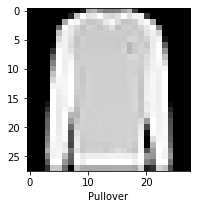

In [133]:
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

import matplotlib.pyplot as plt

plt.figure(figsize=(3,3))

i = 33
# 학습 데이터셋의 i 번째 이미지를 시각화
image = x_train[i]
label = y_train[i]

plt.grid(False)
plt.imshow(image, cmap='gray')
plt.xlabel(class_names[y_train[i]])
plt.show()

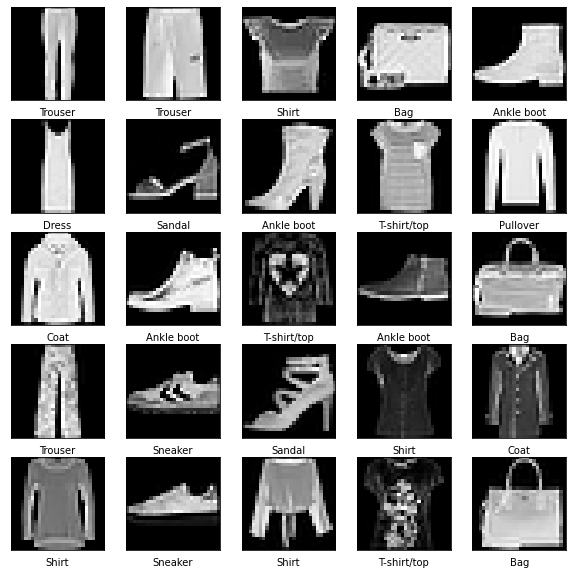

In [134]:
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap='gray')
    plt.xlabel(class_names[y_train[i]])
plt.show()

### 데이터 Normalization

- 이미지 데이터의 픽셀 값은 0~255 사이의 값을 가짐


In [135]:
print('최대 픽셀 값', x_train.max())
print('최소 픽셀 값', x_train.min())

최대 픽셀 값 255.0
최소 픽셀 값 0.0


- 딥러닝 모델 학습 시, 이미지 데이터의 범위를 0~1 사이로 조정

In [136]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [137]:
print('최대 픽셀 값', x_train.max())
print('최소 픽셀 값', x_train.min())

최대 픽셀 값 1.0
최소 픽셀 값 0.0


- Stochastic (Mini-batch) gradient descent 알고리즘을 통한 모델 학습을 위해 데이터를 적절한 크기로 잘라서 학습에 활용
    - Tensorflow의 `Dataset` 패키지를 활용, 전체 데이터를 배치 단위로 분할

In [138]:
batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)


- `Epoch`
    > `Epoch`은 전체 학습 데이터가 신경망을 통과한 횟수. 15-epoch은 전체 학습 데이터가 신경망에 입력되 순전파와 역전파를 통해 신경망을 15번 통과했다는 것을 의미


- 배치 단위로 분할된 `train_ds`, `test_ds`는 아래와 같이 반복문을 통해 iterate 가능 

In [139]:
for x, y in train_ds:
    print(x.shape, y.shape)
    break

(32, 28, 28, 1) (32,)


In [140]:
for x, y in test_ds:
    print(x.shape, y.shape)
    break

(32, 28, 28, 1) (32,)


# 2-1. 모델 정의하기

### Dense (Fully-Connected) Layer

- 입력 vector $x$ 를 받아 학습 파라미터 $W$와의 $W^Tx = y$ 을 수행하는 레이어 

- 입력 벡터가 $x\in \mathbb{R}^{\text{in}}$, 출력 벡터가 $y\in \mathbb{R}^{\text{out}}$의 차원을 갖는 경우 $W$의 차원은 $\mathbb{R}^{\text{in}\times \text{out}}$

- Dense layer 정의

In [141]:

output_dimension = 128
dense_layer = tk.layers.Dense(units=output_dimension, activation='relu')

- 랜덤 입력 데이터 생성

In [142]:
batch_size = 100
input_dimension = 32
input = tf.random.normal(shape=[batch_size, input_dimension])

print('random input shape: ', input.shape)

random input shape:  (100, 32)


- Dense layer 연산 (forward)

In [143]:
output = dense_layer(input)

In [144]:
print('output shape: ', output.shape)

output shape:  (100, 128)


- Dense layer의 학습 파라미터 shape

In [145]:
dense_layer.get_weights()[0].shape

(32, 128)

### Convolution Layer

- (height, width, channel)의 shape을 갖는 이미지 데이터를 입력으로 받아, 컨볼루션 필터를 이용해 이미지 데이터에 대한 합성곱 연산을 수행하는 레이어
- 2차원 이미지 데이터를 dense layer가 처리 가능한 1차원 데이터로 변환하기 위해서 Flatten layer 사용

In [146]:
# filters: 출력 채널 수
# kernel_size: 컨볼루션 핉터 크기
# padding: 입력 이미지에 부여되는 패딩 규칙 ('same' 일 경우 입력과 출력의 너비와 높이가 변하지 않음)
conv_layer = tk.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')

In [147]:
batch_size = 100
input_height = 28
input_width = 28
input_channel = 1
input = tf.random.normal(shape=[100, 28, 28, 1])

print('random input shape: ', input.shape)

random input shape:  (100, 28, 28, 1)


In [148]:
output = conv_layer(input)
output.shape

TensorShape([100, 28, 28, 32])

### Pooling Layer

- Convolution layer를 통해 얻어진 출력 (activation map)으로부터 주요한 정보만을 남기고, 불필요한 정보를 제거하는 레이어 (downsampling 수행)
- `pool_size`가 `k` 일 때 `(height, width, channel)`의 shape을 갖는 입력에 대해 `(height, width//k, channel//k)`의 shape을 갖는 출력 반환

In [149]:
batch_size = 100
input_height = 28
input_width = 28
input_channel = 1
input = tf.random.normal(shape=[100, 28, 28, 1])

print('random input shape: ', input.shape)

random input shape:  (100, 28, 28, 1)


In [150]:
maxpool_layer = tk.layers.MaxPool2D(pool_size=3)

In [151]:
output = maxpool_layer(input)
output.shape

TensorShape([100, 9, 9, 1])

### CNN 모델 정의

- Convolution layer와 pooling layer, dense layer를 조합하여 CNN 모델 정의
- 정의된 CNN 모델의 **출력 차원은 학습 데이터의 클래스 수**와 일치 해야함
    - Fashion MNIST 데이터셋의 경우 총 10개의 클래스 존재

In [152]:
from tensorflow.keras import Model

class cnn_model(Model):
  def __init__(self):
    super(cnn_model, self).__init__()
    self.conv1 = tk.layers.Conv2D(16, 3, activation='relu')
    self.maxpool1 = tk.layers.MaxPool2D(2)

    self.conv2 = tk.layers.Conv2D(32, 3, activation='relu')
    self.maxpool2 = tk.layers.MaxPool2D(2)

    self.flatten = tk.layers.Flatten()
    
    self.dense = tk.layers.Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.maxpool1(x)
    
    x = self.conv2(x)
    x = self.maxpool2(x)
    
    x = self.flatten(x)
    x = self.dense(x)

    return x

# 2-2. 모델 학습

### 모델 인스턴스 생성

- 입력 shape을 지정하여 model build 수행

In [153]:
model = cnn_model()
input_shape = (1,28,28,1)
model.build(input_shape)

In [154]:
model.summary()

Model: "cnn_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          multiple                  160       
                                                                 
 max_pooling2d_7 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          multiple                  4640      
                                                                 
 max_pooling2d_8 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         multiple                  0         
                                                                 
 dense_4 (Dense)             multiple                  

### 모델 학습을 위한 loss 함수와 optimizer 정의

- Tensorflow 에서 지원하는 Loss functions: https://www.tensorflow.org/api_docs/python/tf/keras/losses

    - `CategoricalCrossentropy` : label이 onehot encoding (ex. [0, 0, 0, 1]) 형태로 제공되는 경우 사용
    - `SparseCategoricalCrossentropy` : label이 integer 형태로 제공되는 경우 사용

- Tensorflow 에서 지원하는 Optimizers: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers

In [155]:
# loss 함수 (분류 모델 학습을 위한 Cross Entropy Loss)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

### 학습 및 추론 함수 작성

학습에 필요한 gradient 값을 획득하기 위해서 TF에서 제공하는 `GradientTape()` 함수를 활용

- `GradientTape()` 활용 예시
    - $y=x^2$ 함수에 대한 미분을 계산하는 예시

In [156]:
x = tf.constant(3.0)
with tf.GradientTape() as tape:
  tape.watch(x)
  y = x * x
dy_dx = tape.gradient(y, x)
print(f'x={x}\t', 'dy/dx=2x\t ', dy_dx)

x=3.0	 dy/dx=2x	  tf.Tensor(6.0, shape=(), dtype=float32)


- 학습 함수 정의

In [157]:
from tqdm.notebook import tqdm

In [158]:
def train(model, train_ds, loss_object, optimizer):
  for images, labels in tqdm(train_ds):
    with tf.GradientTape() as tape:
      predictions = model(images)
      loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))  

- 성능 평가 (test) 함수 정의

In [159]:
from sklearn.metrics import accuracy_score

def test(model, test_ds):
    
    preds_list = []
    labels_list = []

    for images, labels in tqdm(test_ds):
        outputs = model(images)

        outputs = outputs.numpy()
        labels = labels.numpy()

        preds = outputs.argmax(axis=1)
        
        preds_list += list(preds)
        labels_list += list(labels)

    accuracy = accuracy_score(labels_list, preds_list)
    return accuracy

    

- 모델 학습

In [160]:
for epoch in range(3):
    train(model, train_ds, loss_object, optimizer)
    acc = test(model, test_ds)
    print(acc)

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

0.7787


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

0.8017


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

0.8224
